<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Visión Computacional </em><br>
    <em>Profesor: Takeshi Asahi </em><br>

</div>

# Machine Learning Avanzado
*22 de Abril de 2024*

#### Integrantes: 
` Giuseppe Lavarello`

## 1. Objetivo

El objetivo principal de esta tarea consiste en implementar mejoras al sistema de clasificación creado en la tarea 2, sobre el conjunto de datos **Brain Tumor MRI Dataset**, disponible en **Kaggle**.

1. Se decidió realizar una mejora al modelo entrenando sobre un modelo preentrenado.
2. La idea de esto es poder comparar los beneficios de especializar un modelo preentrenado versus un modelo creado ad-hoc.
3. Pasos a seguir:
    - Cargar las imágenes.
    - Implementar un sistema de clasificación mediante el modelo Xception.
    - Entrenar el modelo con los datos segmentados.
    - Medir los tiempos de ejecución del procesamiento de las imágenes de prueba.
    - Comparar con el resumen de los resultados del modelo anterior, en particular sus métricas y tiempos.


# 2. Carga de datos

In [16]:


# manejo datos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# visualización y gráficos
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
# Os y glob para manejo de archivos
import os
from glob import glob

# Modelos
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

# Configuración de TensorFlow para evitar advertencias y errores de GPU
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
absl.logging.set_verbosity('error')  # or 'fatal'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

#medicion de ejecucion
import time

**Decisión**  
En esta tarea, a diferencia de la anterior, se creará un dataframe que contenga el `path` y la `clase` de cada imagen. Esto permitirá realizar el preprocesamiento directamente con la librería `ImageDataGenerator` de Keras.


In [17]:
def load_paths(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes}) # DataFrame con rutas y etiquetas
    return tr_df

In [18]:
tr_df = load_paths(r'./data/Training')
ts_df = load_paths(r'./data/Testing')


In [19]:
# Visualización de las clases y sus conteos
def plot_class_distribution(df):
    """ Visualiza la distribución de clases en el conjunto de entrenamiento.
    Args:
        tr_df (DataFrame): DataFrame que contiene las rutas de las imágenes y sus etiquetas.
    """

    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    ax = sns.countplot(data=df, x='Class', order=tr_df['Class'].value_counts().index)

    ax.set_title('Distribución de Clases en el Conjunto de Entrenamiento')
    ax.set_xlabel('Clases')
    ax.set_ylabel('Conteo')
    plt.xticks(rotation=25)


    # añadir cantidad dentro de las barras
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()//2), 
                    ha='center', 
                    va='bottom', 
                    fontsize=15, 
                    color='w', 
                    weight='bold', 
                    rotation=90, 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    #añadir total de imágenes arriba a la derecha 
    total = len(df)
    ax.annotate(f'Total de imagenes: {total}', 
                (0.9, 0.90), 
                xycoords='axes fraction', 
                ha='right', 
                va='top', 
                fontsize=15, 
                color='black',  
                rotation=0, 
                xytext=(0, 5), 
                textcoords='offset points')
    plt.tight_layout()
    plt.show()

**Decisión**  
Dado que no hay datos de validación, separamos aleatoriamente los datos de prueba en dos grupos: 50% para validación y 50% para prueba.


In [20]:
val_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=1122, stratify=ts_df['Class'])

En los siguientes diagramas podemos ver que el dataset se compone de 3 grupos: `ts_df`, `val_df` y `tr_df`. Cada uno contiene imágenes de las 4 clases presentes en los datos: `notumor`, `pituitary`, `meningioma` y `glioma`. El conjunto `tr_df` consiste en 5712 imágenes, `ts_df` en 656 imágenes y `val_df` en una cantidad de imágenes no especificada.


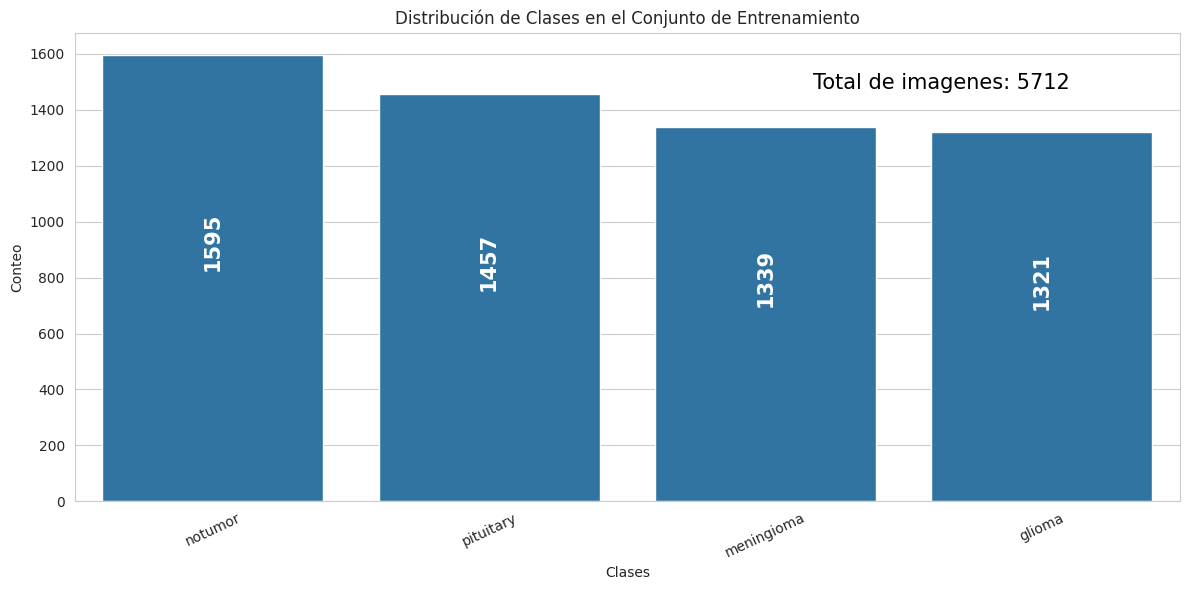

In [21]:
plot_class_distribution(tr_df)

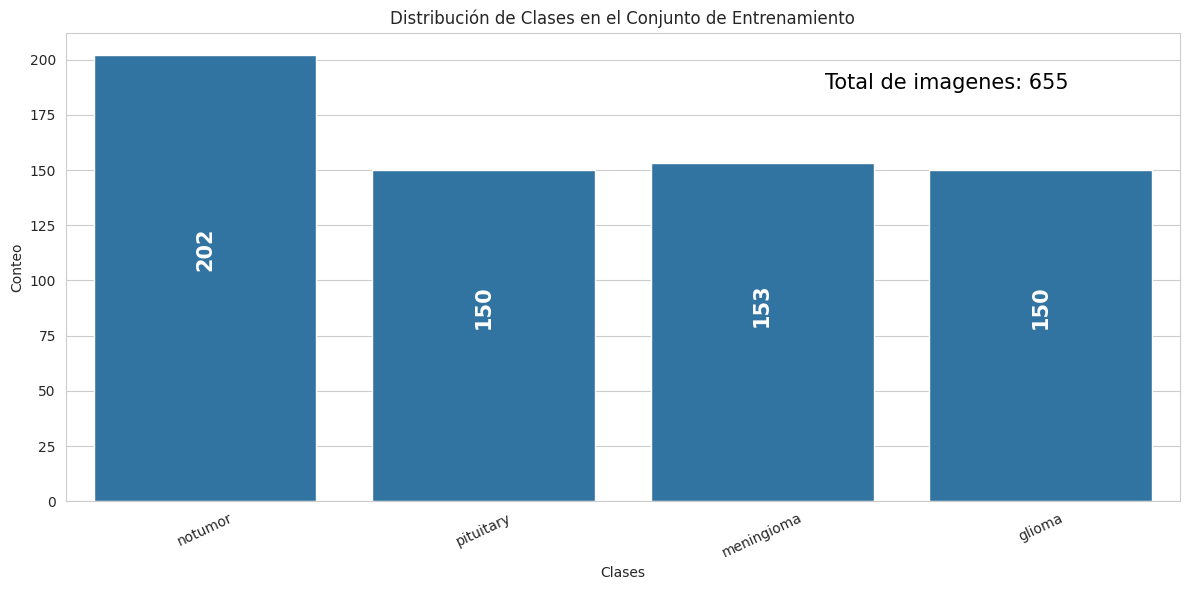

In [22]:
plot_class_distribution(val_df)

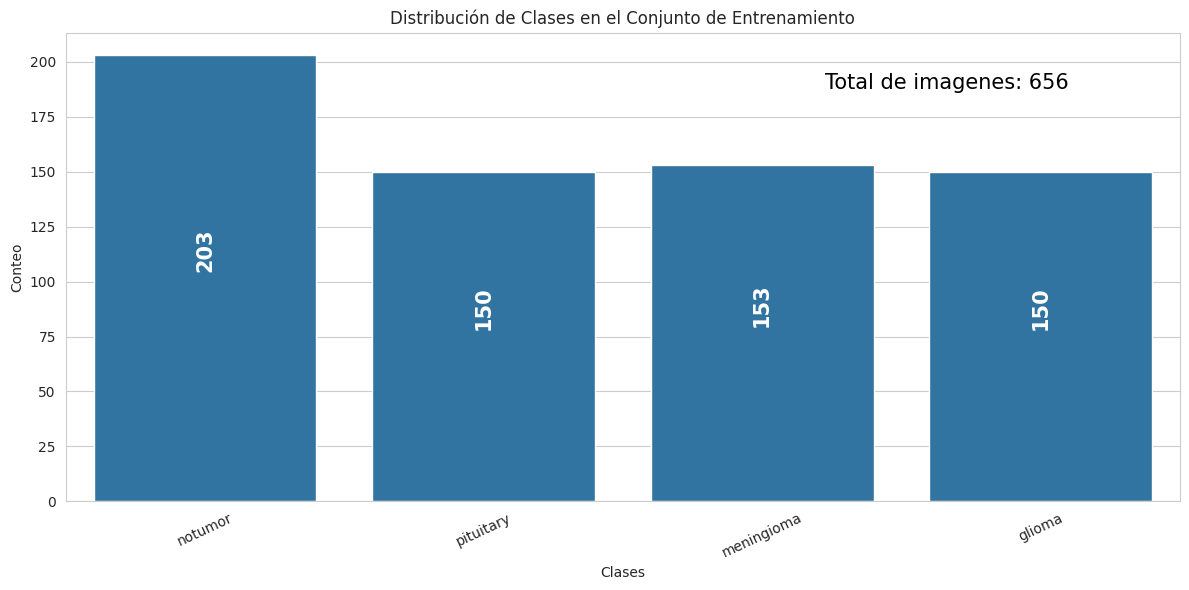

In [23]:
plot_class_distribution(ts_df)

**Importante**  
Aunque existe un pequeño desbalance en los datos a favor de la clase `notumor`, este no es lo suficientemente significativo como para justificar una limpieza más profunda en esta etapa. Sin embargo, en las siguientes iteraciones de esta tarea se trabajará para tratar de obtener mejores resultados.


In [24]:
tr_df.describe()

,Class Path,Class
count,5712,5712
unique,5712,4
top,./data/Training/pituitary/Tr-pi_1440.jpg,notumor
freq,1,1595


In [25]:
val_df.describe()

,Class Path,Class
count,655,655
unique,655,4
top,./data/Testing/pituitary/Te-pi_0297.jpg,notumor
freq,1,202


In [26]:
ts_df.describe()

,Class Path,Class
count,656,656
unique,656,4
top,./data/Testing/meningioma/Te-me_0112.jpg,notumor
freq,1,203


# 3. Preprocesamiento
Se crean los manipuladores de imagen y se realizan tres tratamientos distintos para generar diferentes conjuntos de datos. 

1. En la primera iteración, las imágenes son reescaladas y convertidas a escala de grises.



In [27]:

batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, # reescalado de imagenes
                                    # color_mode='grayscale', # cambio a greyscale

                                  )

valid_gen = _gen.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, # reescalado de imagenes)
                                        # color_mode='grayscale', # cambio a greyscale 

                                     )

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', batch_size=16,
                                    target_size=img_size, # reescalado de imagenes)
                                    # color_mode='grayscale', # cambio a greyscale
                                    shuffle=False)




Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 3.1 Muestra de imagenes

1. Las imagenes se presentan con buen contraste y escala. Es importante notar que el corte de la imagen esta en diferentes orientaciones, lo que puede confundir al modelo.

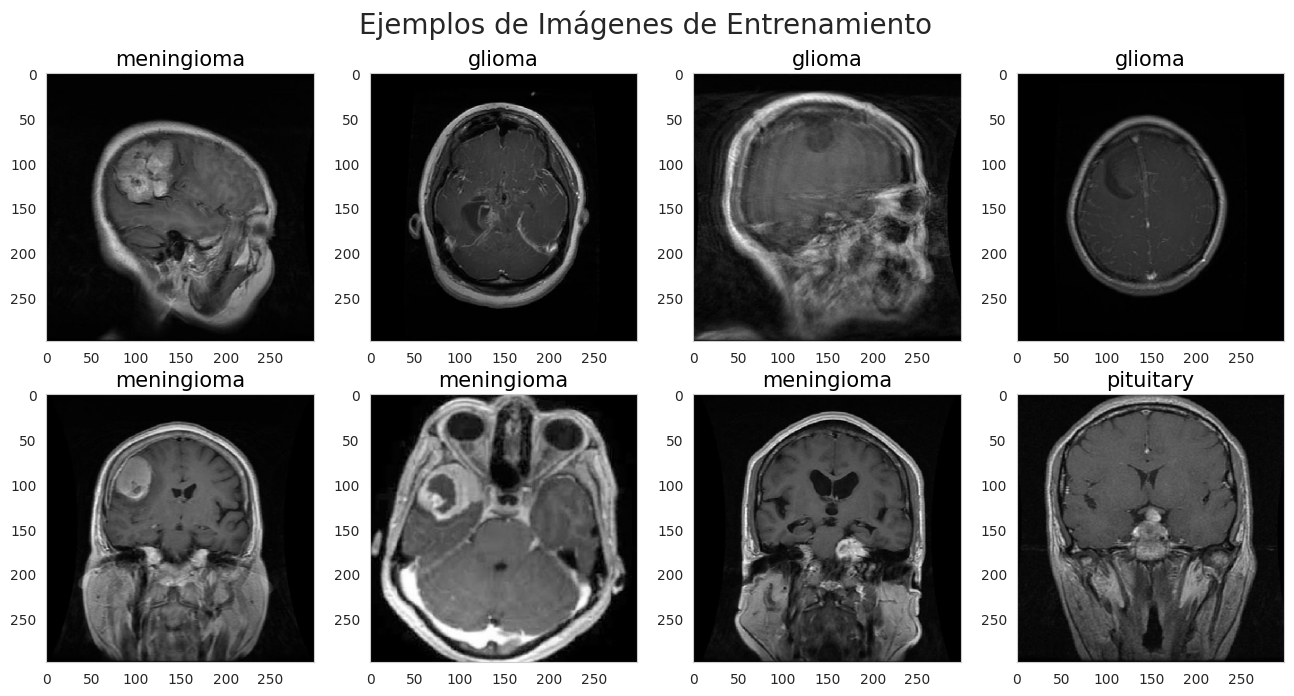

In [28]:
classes = list(tr_gen.class_indices.keys())
images, labels = next(tr_gen)

def plot_images(images, labels, classes, title):
    plt.figure(figsize=(16, 16))
    plt.suptitle(title, fontsize=20, y=0.92)
    for i, (image, label) in enumerate(zip(images, labels)):
        if i >= 8:
            break
        plt.subplot(4,4, i + 1)
        plt.imshow(image, cmap='gray')
        class_name = classes[np.argmax(label)]
        plt.title(class_name, color='k', fontsize=15)
        plt.grid(False)

    plt.show()
plot_images(images, labels, classes, title='Ejemplos de Imágenes de Entrenamiento')


In [29]:
# Definición del modelo

epocas = 10
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')  

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Cada modelo se entrena antes de crear el siguiente.


In [30]:
checkpoint_filepath = 'modelo_Xception.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy', 
    save_best_only=True,   
    mode='max',            
    verbose=1              
)

hist = model.fit(tr_gen,
                     epochs=epocas,
                     validation_data=valid_gen,
                     shuffle= False,
                     callbacks=[model_checkpoint_callback]
                     )




Epoch 1/10


I0000 00:00:1749425840.790814   27636 service.cc:152] XLA service 0x7f50bc002300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749425840.790850   27636 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-06-08 19:37:21.433004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749425843.197369   27636 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749425880.318925   27636 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7674 - loss: 0.6781 - precision: 0.8342 - recall: 0.6648

2025-06-08 19:39:45.320604: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 4 bytes spill stores, 4 bytes spill loads

2025-06-08 19:39:50.272522: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 12 bytes spill stores, 12 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.92977, saving model to modelo_Xception.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 173s 661ms/step - accuracy: 0.7681 - loss: 0.6762 - precision: 0.8347 - recall: 0.6658 - val_accuracy: 0.9298 - val_loss: 0.1662 - val_precision: 0.9470 - val_recall: 0.9282
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9740 - loss: 0.0740 - precision: 0.9752 - recall: 0.9730
Epoch 2: val_accuracy did not improve from 0.92977
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 433ms/step - accuracy: 0.9740 - loss: 0.0739 - precision: 0.9753 - recall: 0.9731 - val_accuracy: 0.9008 - val_loss: 0.2634 - val_precision: 0.9098 - val_recall: 0.8931
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9925 - loss: 0.0254 - precision: 0.9926 - recall: 0.9923
Epoch 3: val_accuracy improved from 0.92977 to 0.98779, saving model to modelo_Xception.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 439ms/step - accuracy: 0.9925 - loss: 0.0254 - precision: 0.9926 - recall: 

In [31]:
def plot_training_history(hist):
    """ Visualiza la historia de entrenamiento del modelo.
    Args:
        hist (History): Historia de entrenamiento del modelo.
    """
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    tr_per = hist.history['precision']
    tr_recall = hist.history['recall']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    val_per = hist.history['val_precision']
    val_recall = hist.history['val_recall']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_precision = np.argmax(val_per)
    per_highest = val_per[index_precision]
    index_recall = np.argmax(val_recall)
    recall_highest = val_recall[index_recall]

    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best epoch = {str(index_loss + 1)}'
    acc_label = f'Best epoch = {str(index_acc + 1)}'
    per_label = f'Best epoch = {str(index_precision + 1)}'
    recall_label = f'Best epoch = {str(index_recall + 1)}'


    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')


    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label, zorder=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label, zorder=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label, zorder=2)
    plt.title('Precision and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label, zorder=2)
    plt.title('Recall and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    #make yticks percentage
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    plt.show()

El modelo original se estabiliza rápidamente, obteniendo pequeñas ganancias después de la cuarta iteración.


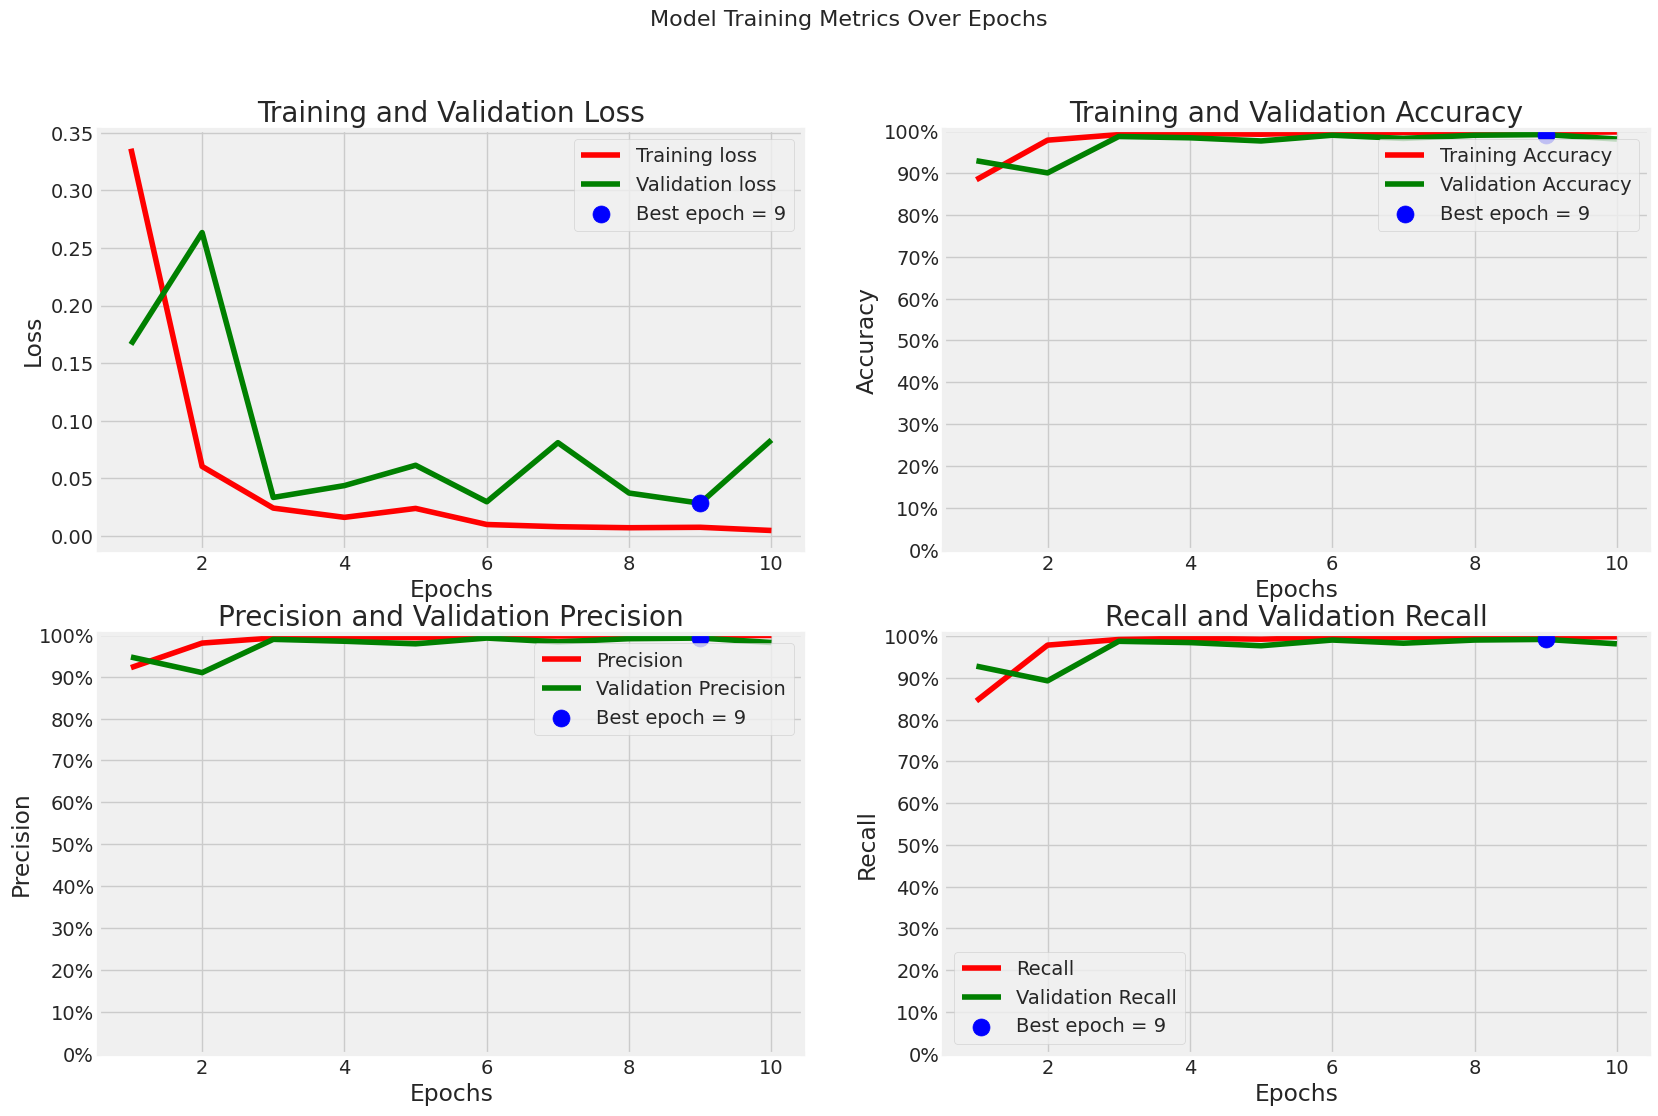

In [32]:
plot_training_history(hist)

# 4. Tiempo de Procesamiento


Una vez entrenados los modelos, se mide el tiempo de procesamiento del conjunto de prueba y, finalmente, se obtiene la matriz de confusión de cada modelo.


## 4.1 Todas las imagenes

In [33]:
repeticiones = 10
tiempo = []
for i in range(repeticiones):
    start_time = time.time()
    pred = model.predict(ts_gen)
    end_time = time.time()
    tiempo.append({"tiempo" :end_time - start_time})

df_tiempo = pd.DataFrame(tiempo)

y_pred = np.argmax(pred, axis=1)

2025-06-08 19:53:32.736708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1017', 12 bytes spill stores, 12 bytes spill loads



41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


In [34]:
df_tiempo.head(10)


,tiempo
0,5.730340
1,2.827013
2,3.031943
3,3.018111
4,2.986725
5,2.978631
6,2.924671
7,2.912840
8,3.009794
9,2.055346


## 4.2 Mitad de las Imagenes 

In [35]:
total_muestras=len(ts_gen.filenames) # total de imagenes en el generador de test
steps= int((total_muestras/ts_gen.batch_size)//2) # pasos por epoca

In [37]:
tiempo_mitad = []
for i in range(repeticiones):
    start_time = time.time()
    pred_mitad = model.predict(ts_gen, steps=steps) # prediccion con el modelo rotado y desplazado
    end_time = time.time()
    tiempo_mitad.append({"tiempo_mitad" :end_time - start_time})

df_tiempo_mitad = pd.DataFrame(tiempo_mitad)

y_pred_mitad = np.argmax(pred_mitad, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


In [38]:
# Se crea el dataframe final con los tiempos de cada modelo
df_tiempo_mitad_final = df_tiempo_mitad
df_tiempo_final = df_tiempo.join(df_tiempo_mitad_final, how='outer')
df_tiempo_final.head(10)

,tiempo,tiempo_mitad
0,5.730340,1.983467
1,2.827013,1.632665
2,3.031943,1.796651
3,3.018111,1.696665
4,2.986725,1.772037
5,2.978631,1.739300
6,2.924671,1.725943
7,2.912840,1.675917
8,3.009794,1.743794
9,2.055346,0.872036


In [39]:
# Obtenemos las medidas estadisticas de los tiempos de cada modelo 
df_tiempo_final.describe()

,tiempo,tiempo_mitad
count,10.000000,10.000000
mean,3.147541,1.663847
std,0.953049,0.293750
min,2.055346,0.872036
25%,2.915798,1.681104
50%,2.982678,1.732621
75%,3.016032,1.764976
max,5.730340,1.983467


Text(0, 0.5, 'Tiempo (segundos)')

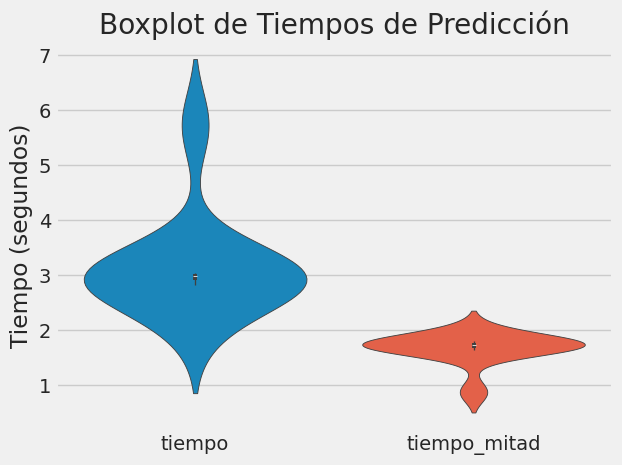

In [45]:
sns.violinplot(data=df_tiempo_final, orient='v',)
plt.title('Boxplot de Tiempos de Predicción')
plt.ylabel('Tiempo (segundos)')

Finalmente, se obtienen los resultados estadísticos del tiempo de procesamiento, donde se puede observar que, si bien la media varía, existe una relación directa entre el tiempo y la cantidad de imágenes procesadas. Es imporante notar tambien que la desviación estandar es mucho menor en el caso de la mitad de las imagenes.


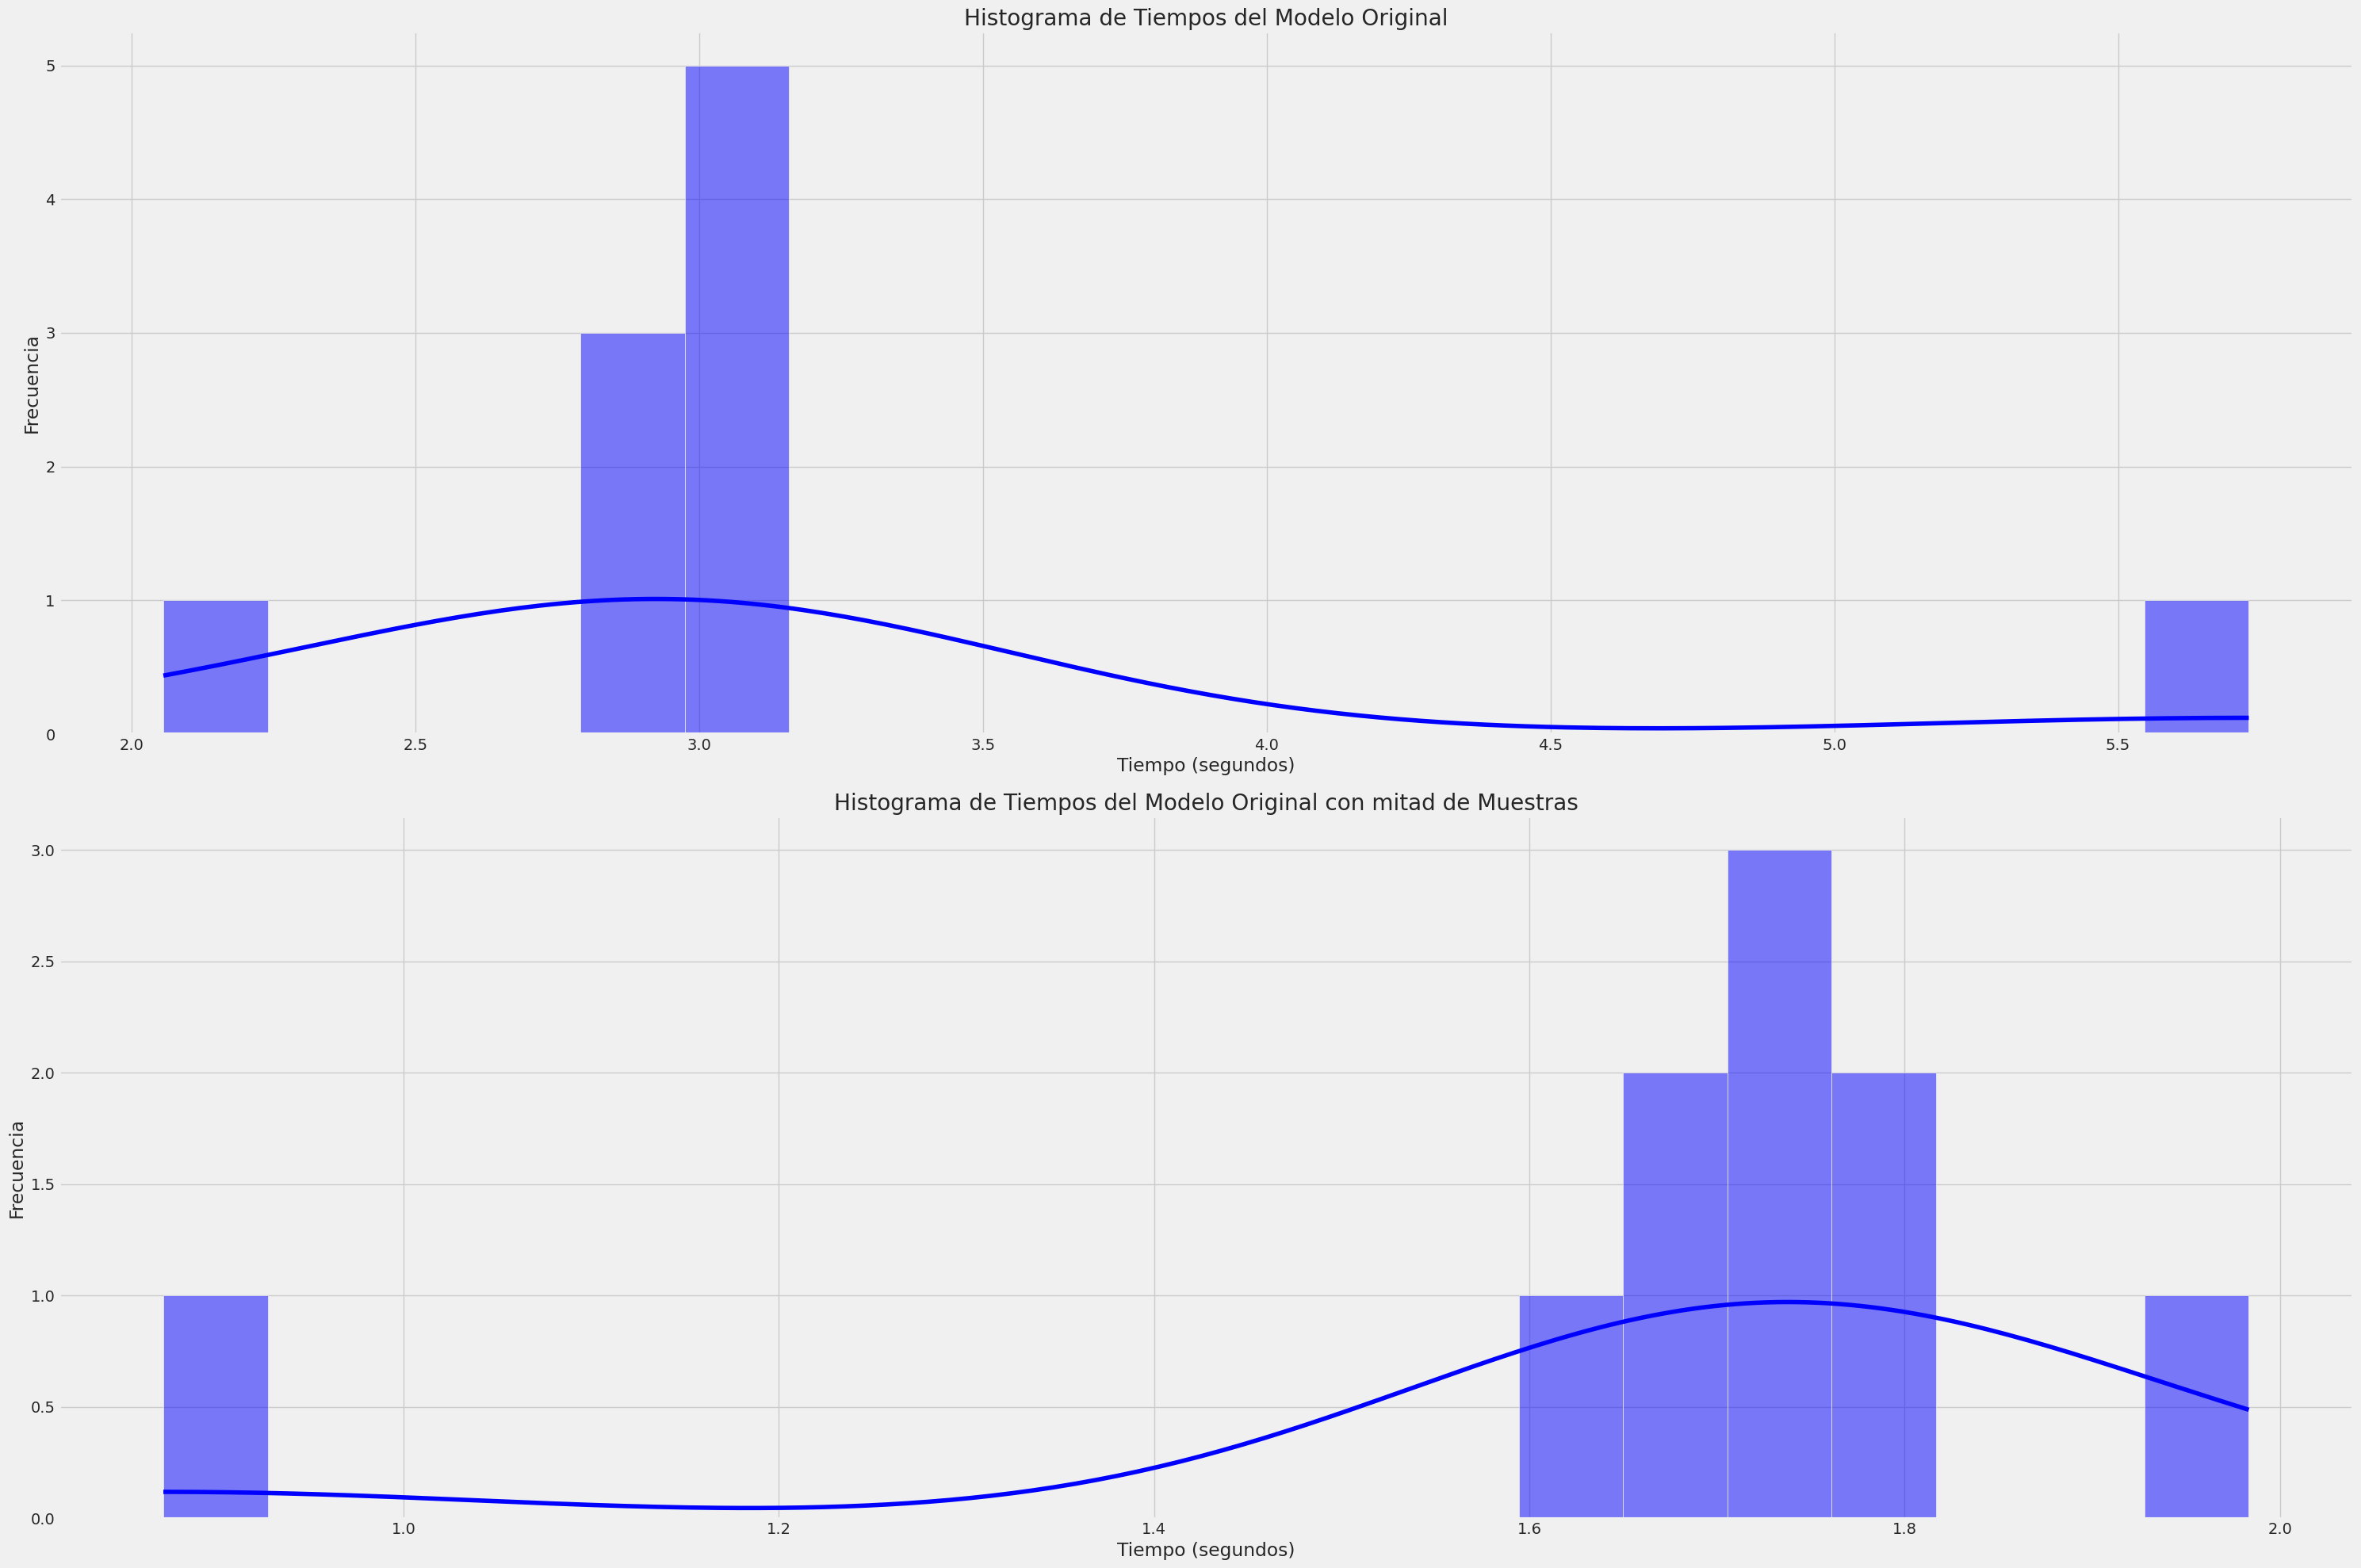

In [49]:
# plot de histograma de las estadisticas de los tiempos de cada modelo

fig, axs = plt.subplots(2, 1, figsize=(30, 20))
axs = axs.flatten()
sns.histplot(df_tiempo_final['tiempo'], kde=True, bins=20, color='blue', ax=axs[0])
sns.histplot(df_tiempo_final['tiempo_mitad'], kde=True, bins=20, color='blue', ax=axs[1])

axs[0].set_title('Histograma de Tiempos del Modelo Original')
axs[1].set_title('Histograma de Tiempos del Modelo Original con mitad de Muestras')
axs[0].set_ylabel('Frecuencia')
axs[1].set_ylabel('Frecuencia')
axs[0].set_xlabel('Tiempo (segundos)')
axs[1].set_xlabel('Tiempo (segundos)')

plt.tight_layout()

# 5. Resultados del procesamiento

**Importante**  
Para la predicción se utilizara el modelo de la epoca con mejor `val_accuracy`

## 5.1 Modelo Original

El modelo presenta un exelente rendimiento en las todas clases, sin embargo, es posible que presente un overfitting al set utilizado, ideamente se obtendrian nuevas imagenes para testearlo pero se puede lograr un efecto similar procesando las imagenes de testeo, lo que queda abierto para futuras iteraciones.


In [50]:
best_model = tf.keras.models.load_model(checkpoint_filepath)
predicted_classes = best_model.predict(ts_gen)
y_pred = np.argmax(predicted_classes, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step


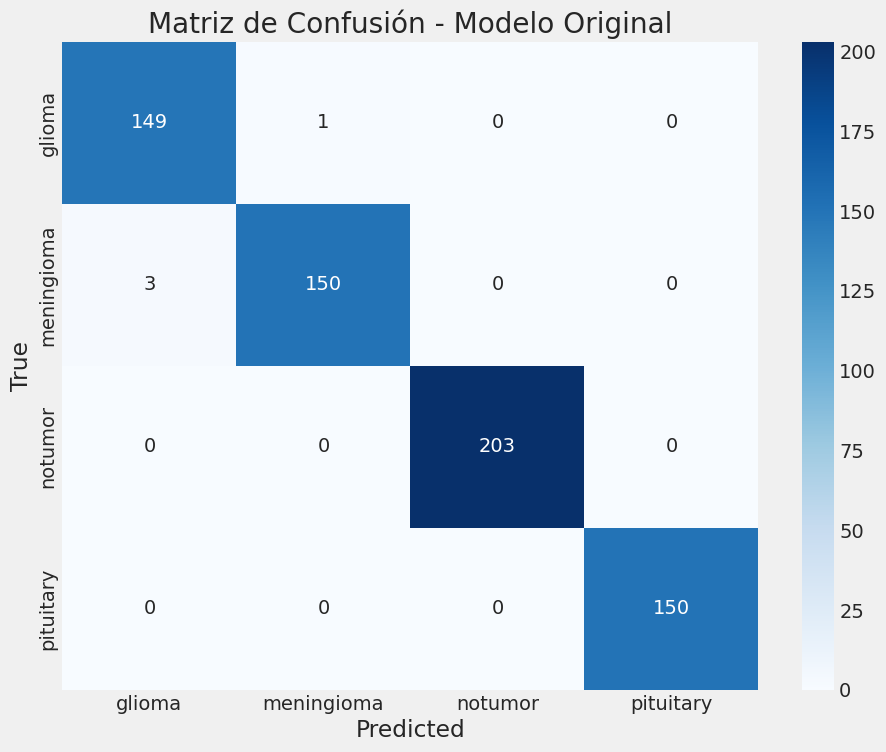

In [51]:

def confusion_matrix_plot(y_predicho, title='Confusion Matrix'):
    cm = confusion_matrix(ts_gen.classes, y_predicho)
    clases= list(ts_gen.class_indices.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
    

confusion_matrix_plot(y_pred, title='Matriz de Confusión - Modelo Original')





In [52]:
from sklearn.metrics import classification_report

print(classification_report(ts_gen.classes, y_pred, target_names=ts_gen.class_indices.keys()))


              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       150
  meningioma       0.99      0.98      0.99       153
     notumor       1.00      1.00      1.00       203
   pituitary       1.00      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



El modelo se presenta muy robusto para la mayoría de los casos. Existe mínima confusión en el caso de glioma con meningioma, presentando una excelente herramienta para el análisis médico.


## 5.2 Comparación con tarea 2
### 5.2.1 Tiempos Tarea 2
| Index | tiempo | tiempo_mitad |
|-------|--------|--------------|
| 0     | 4.053777 | 1.301631     |
| 1     | 2.271318 | 1.217973     |
| 2     | 2.290299 | 1.227451     |
| 3     | 2.323420 | 1.242543     |
| 4     | 2.291818 | 1.153551     |
| 5     | 2.341769 | 1.182495     |
| 6     | 2.240010 | 1.236554     |
| 7     | 2.101280 | 1.199299     |
| 8     | 2.121798 | 1.169695     |
| 9     | 2.241447 | 1.101418     |

In [65]:
data = {
    'tiempo_tarea2': [4.053777, 2.271318, 2.290299, 2.323420, 2.291818, 2.341769, 2.240010, 2.101280, 2.121798, 2.241447],
    'tiempo_mitad_tarea2': [1.301631, 1.217973, 1.227451, 1.242543, 1.153551, 1.182495, 1.236554, 1.199299, 1.169695, 1.101418]
}

df_tiempos_2 = pd.DataFrame(data)
df_tiempo_final = df_tiempo_final.join(df_tiempos_2, how='outer')

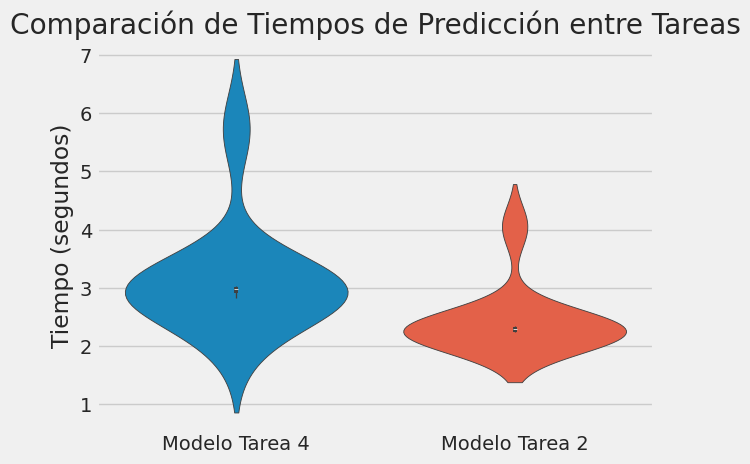

In [71]:
# comparación de tiempos entre el modelo original y el modelo de la tarea 2

sns.violinplot(data=df_tiempo_final[["tiempo","tiempo_tarea2"]],  orient='v')
plt.title('Comparación de Tiempos de Predicción entre Tareas') 

plt.xticks([0, 1], ['Modelo Tarea 4', 'Modelo Tarea 2'])
plt.ylabel('Tiempo (segundos)')

plt.show()

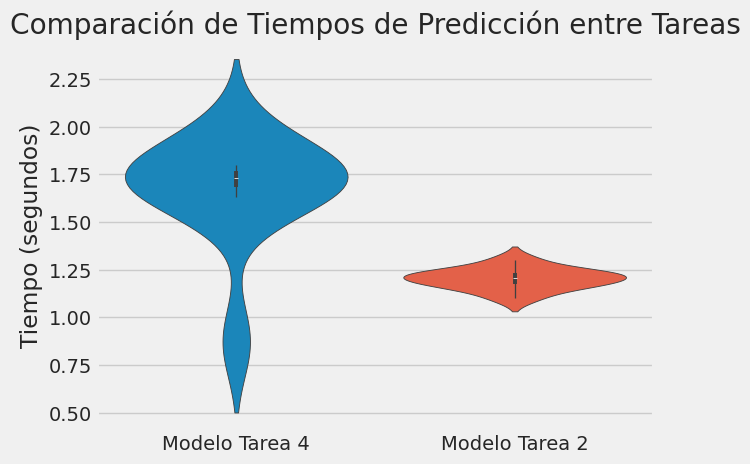

In [72]:
# comparación de tiempos entre el modelo original y el modelo de la tarea 2

sns.violinplot(data=df_tiempo_final[["tiempo_mitad","tiempo_mitad_tarea2"]],  orient='v')
plt.title('Comparación de Tiempos de Predicción entre Tareas') 

plt.xticks([0, 1], ['Modelo Tarea 4', 'Modelo Tarea 2'])
plt.ylabel('Tiempo (segundos)')

plt.show()

De los gráficos se puede ver que el modelo de la tarea 2 es ligeramente más rápido, pero no parece ser un beneficio significativo con respecto al modelo de la tarea 4 al crecer el número de imágenes.


### 5.2.2 Comparación de metricas

| class        |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| glioma       |        0.92 |     0.95 |       0.94 |       150 |
| meningioma   |        0.95 |     0.9  |       0.93 |       153 |
| notumor      |        0.99 |     1    |       0.99 |       203 |
| pituitary    |        1    |     1    |       1    |       150 |
| accuracy     |      nan    |   nan    |     nan    |       656 |
| macro avg    |        0.96 |     0.96 |       0.96 |       656 |
| weighted avg |        0.97 |     0.97 |       0.97 |       656 |

In [77]:
metricas_tarea2 = {
    'class': ['glioma', 'meningioma', 'notumor', 'pituitary', 'accuracy', 'macro avg', 'weighted avg'],
    'precision': [0.92, 0.95, 0.99, 1.00, None, 0.96, 0.97],
    'recall': [0.95, 0.90, 1.00, 1.00, None, 0.96, 0.97],
    'f1-score': [0.94, 0.93, 0.99, 1.00, 0.97, 0.96, 0.97],
    'support': [150, 153, 203, 150, 656, 656, 656]
}

df_metricas_t2 = pd.DataFrame(metricas_tarea2)

In [78]:
df_metricas_t2

,class,precision,recall,f1-score,support
0,glioma,0.92,0.95,0.94,150
1,meningioma,0.95,0.90,0.93,153
2,notumor,0.99,1.00,0.99,203
3,pituitary,1.00,1.00,1.00,150
4,accuracy,NaN,NaN,0.97,656
5,macro avg,0.96,0.96,0.96,656
6,weighted avg,0.97,0.97,0.97,656


In [76]:
print(classification_report(ts_gen.classes, y_pred, target_names=ts_gen.class_indices.keys()))

              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       150
  meningioma       0.99      0.98      0.99       153
     notumor       1.00      1.00      1.00       203
   pituitary       1.00      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



Es fácil ver que el nuevo modelo es significativamente más seguro que el anterior, con un poder predictivo que suple el hecho de que es ligeramente más lento.


# 6. Conclusiones

El nuevo modelo, basado en el modelo preentrenado Xception, presenta una mejora significativa sobre el modelo anterior, esto al costo del control que se tiene sobre el modelo, además de los posibles casos de restricción basados en la licencia de uso.  
Una posible línea de mejora, que se mantiene de la tarea anterior, radica en que las imágenes médicas tienden a seguir estándares consistentes en cuanto a orientación, resolución y tipo de corte. Por lo tanto, la necesidad de una generalización extensiva no resulta tan relevante en este contexto.

Siguiendo esta línea, una posible estrategia futura sería separar las imágenes según su tipo de corte (axial, coronal, sagital) y entrenar modelos específicos para cada uno de ellos. Esto podría reducir la ambigüedad en la clasificación y facilitar el desarrollo de un modelo aplicable en entornos reales.

En esta tarea se intentó separar las imágenes según el corte, pero finalmente se decidió cambiar la dirección del entrenamiento, dado que, al no estar preclasificadas, la clusterización que se estaba realizando mediante MobileNetV2, PCA y KNN generaba clases con bastante superposición.  
Si desean ver el código utilizado, se encuentra en este link: https://github.com/Gaddran/Computer-Vision/blob/main/v0_Tarea_4.ipynb
